In [170]:
!pip3 install sparqlwrapper
!conda install -c conda-forge rdkit -y
!conda install matplotlib -y
!conda install numpy scipy scikit-learn -y
!conda config --add channels conda-forge
!conda install catboost -y
!conda install tqdm -y
!conda install xgboost -y 
!conda install hyperopt -y
!pip3 install tensorflow-gpu
!pip3 install pydot
!pip3 install tensorflow_probability
!pip3 install tensorflow_addons

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [171]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

DATASET = 'LC50'

training_file = f'./test_data/DataSets/{DATASET}_training.sdf'
testing_file = f'./test_data/DataSets/{DATASET}_prediction.sdf'


train_frame = PandasTools.LoadSDF(training_file,
                            smilesName='SMILES',
                            molColName='Molecule')

test_frame = PandasTools.LoadSDF(testing_file,
                            smilesName='SMILES',
                            molColName='Molecule')


In [172]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/
from collections import defaultdict
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """select ?from ?to where{
  ?chem wdt:P231 ?from ;
        wdt:P592 ?to .
}"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

mapping = defaultdict(lambda : 'no mapping')

for result in results["results"]["bindings"]:
    mapping[result['from']['value']] = result['to']['value']
   

In [173]:
train_frame['CHEMBL'] = [mapping[cas.upper()] for cas in train_frame['CAS']]
test_frame['CHEMBL'] = [mapping[cas.upper()] for cas in test_frame['CAS']]

In [174]:
#train_frame = train_frame.drop(train_frame[train_frame.CHEMBL=='no mapping'].index,axis=0).reset_index(drop=True)
#test_frame = test_frame.drop(test_frame[test_frame.CHEMBL=='no mapping'].index,axis=0).reset_index(drop=True)

In [175]:
train_frame.shape,test_frame.shape

((659, 8), (164, 8))

In [176]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
x = train_frame['Tox'].astype(float).values

mean = np.mean(x)
std = np.std(x)

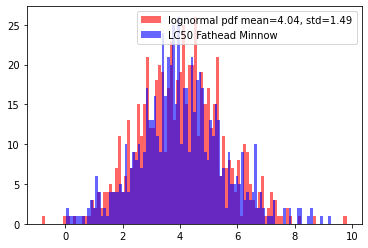

In [177]:
plt.hist(np.log(np.random.lognormal(mean=mean, sigma=std, size=x.shape)),color='r',bins=100, lw=5, alpha=0.6, label=f'lognormal pdf mean={round(mean,2)}, std={round(std,2)}')
plt.hist(train_frame['Tox'].astype(float).values,color='b', bins=100,lw=5, alpha=0.6, label='LC50 Fathead Minnow')
plt.legend()

In [178]:
def get_fingerprints(frame):
    
    ms = [Chem.MolFromSmiles(smiles) for smiles in frame.SMILES]
    fps = [list(Chem.RDKFingerprint(x).GetOnBits()) for x in ms]
    fp_max = max([max(fp) for fp in fps])
    v = np.zeros((len(fps),fp_max+1))
    for i,fp_idx in enumerate(fps):
        v[i,fp_idx] = 1
    return v
    

In [179]:
X_train = get_fingerprints(train_frame)
X_test = get_fingerprints(test_frame)
y_train = train_frame['Tox'].astype(float).values
y_test = test_frame['Tox'].astype(float).values
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((659, 2048), (164, 2048), (659,), (164,))

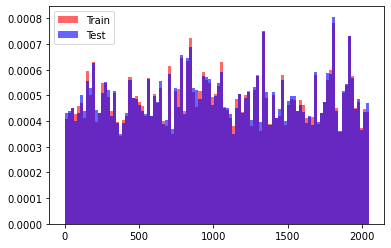

In [180]:
X_train_idx = np.where(X_train == 1)[1]
X_test_idx = np.where(X_test == 1)[1]
plt.hist(X_train_idx,bins=100,color='r',lw=5,alpha=0.6,label='Train',density=True)
plt.hist(X_test_idx,bins=100,color='b',lw=5,alpha=0.6,label='Test',density=True)
plt.legend()

In [181]:
#import tensorflow as tf

#encoder = tf.keras.models.Sequential([tf.keras.layers.Dense(512,activation='relu'),
 #                                    tf.keras.layers.Dense(128,activation='relu')])

#decoder = tf.keras.models.Sequential([tf.keras.layers.Dense(512,activation='relu'),
  #                                   tf.keras.layers.Dense(X_train.shape[-1],activation='sigmoid')])

#autoencoder = tf.keras.models.Sequential([encoder,decoder])
#autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
#autoencoder.fit(X_train,X_train,epochs=2000,batch_size=1024)

#X_train = encoder.predict(X_train)
#X_test = encoder.predict(X_test)

In [182]:
import tensorflow as tf
import tensorflow.keras.backend as K

class RSquared(tf.keras.metrics.Metric):
    def __init__(self,name='r_squared',**kwargs):
        super(RSquared, self).__init__(name=name, **kwargs)
        self.r2 = self.add_weight(name='r2', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        SS_res = K.sum(K.square( y_true-y_pred ))
        SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
        
        self.r2.assign_add(1 - SS_res/(SS_tot + K.epsilon()))

    def result(self):
        return self.r2
    
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [183]:
import random
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [184]:
def robust_loss(alpha=1,c=1):
    assert c > 0
    #https://openaccess.thecvf.com/content_CVPR_2019/papers/Barron_A_General_and_Adaptive_Robust_Loss_Function_CVPR_2019_paper.pdf
    def loss(y_true,y_pred):
        e = y_true - y_pred
        if alpha == 2:
            l = 0.5 * (e/c)**2
        elif alpha == 0:
            l = tf.math.log(0.5*(e/c)**2 + 1)
        else:
            a = abs(alpha-2)/alpha
            div = tf.math.pow(e/c,2) / abs(alpha-2)
            div = tf.math.pow(div+1,alpha/2)
            l = a * (div - 1)
        return tf.reduce_mean(l)
    
    return loss
        

In [185]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow_addons as tfa

def create_model(space):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Embedding(len(np.unique(X_train[0])),space['embedding_dim'],input_length=X_train.shape[-1],
                                        embeddings_initializer=tf.keras.initializers.GlorotNormal()))
    
    #model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,kernel_initializer=tf.keras.initializers.HeNormal()),merge_mode='concat'))
    #model.add(tf.keras.layers.Conv1D(32,3,activation='relu'))
    #model.add(tf.keras.layers.AveragePooling1D(3))
    
    model.add(tf.keras.layers.Flatten())
    
    for i in range(space['num_layers']):
        model.add(tf.keras.layers.Dense(space[f'units_{i}'],
                                        kernel_initializer=tf.keras.initializers.GlorotNormal()))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
        model.add(tf.keras.layers.Dropout(space[f'dropout_{i}']))
    model.add(tf.keras.layers.Dense(1,bias_initializer=tf.keras.initializers.Constant(y_train.mean()),
                                   kernel_initializer=tf.keras.initializers.GlorotNormal()))
    model.compile(optimizer=tf.keras.optimizers.SGD(space['learning_rate']),
                  loss=tf.keras.losses.MeanSquaredError(),
                 metrics = [coeff_determination])
    return model

model=create_model(defaultdict(lambda : 1))
tf.keras.utils.plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [186]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
import warnings

FOLDS = len(y_train)//len(y_test)

def objective(space):
    
    oof = np.zeros(y_train.shape)
    for fold,(train_idx,test_idx) in enumerate(KFold(FOLDS).split(y_train)):
        
        regr = create_model(space)
        hist = regr.fit(X_train[train_idx],y_train[train_idx],
                validation_data=(X_train[test_idx],y_train[test_idx]),
                epochs=1000,
                batch_size=16,
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping('val_loss',patience=20,
                                                           restore_best_weights=True)])
        
        oof[test_idx] += regr.predict(X_train[test_idx]).ravel()
        
    try:
        r2 = r2_score(y_train,oof)
    except:
        r2 = 0
        
    CrossValMean = 1 - r2
    
    return{'loss':CrossValMean, 'status': STATUS_OK}

    
max_layers = 4
space = {'num_layers':hp.choice('num_layers',range(1,max_layers)),
        'learning_rate':hp.quniform('learning_rate',1e-4,1e-2,1e-5),
        'embedding_dim':hp.choice('embedding_dim',range(4,33))}
for i in range(max_layers):
    space[f'units_{i}'] = hp.choice(f'units_{i}',range(64,512))
    space[f'dropout_{i}'] = hp.quniform(f'dropout_{i}',0.1,0.5,0.1)

trials = Trials()
#best = fmin(fn=objective,
#            space=space,
#            algo=tpe.suggest,
#            max_evals=50,
#            trials=trials)
#print("Best: ", best)

In [192]:
best = {'num_layers':1,
        'learning_rate':0.001,
        'units_0':348,
        'dropout_0':0.4,
        'embedding_dim':14}

set_all_seeds(42)

oof = np.zeros(y_train.shape)
models = []
for fold, (train_idx,test_idx) in enumerate(KFold(FOLDS).split(y_train)):
    regr = create_model(best)
    hist = regr.fit(X_train[train_idx],y_train[train_idx],
                validation_data = (X_train[test_idx],y_train[test_idx]),
                epochs=200,
                batch_size=16,
                verbose=2,
                callbacks=[tf.keras.callbacks.EarlyStopping('val_loss',
                                                            patience=20,restore_best_weights=True),
                          tf.keras.callbacks.ReduceLROnPlateau('val_loss',patience=3)])
    
    oof[test_idx] += regr.predict(X_train[test_idx]).ravel()
    models.append(regr)


Epoch 1/200
31/31 - 1s - loss: 2.8109 - coeff_determination: -8.9537e-01 - val_loss: 2.0061 - val_coeff_determination: -1.1331e-02
Epoch 2/200
31/31 - 1s - loss: 2.0872 - coeff_determination: -1.9736e-01 - val_loss: 2.0664 - val_coeff_determination: 0.0101
Epoch 3/200
31/31 - 1s - loss: 1.5962 - coeff_determination: 0.1335 - val_loss: 1.7765 - val_coeff_determination: 0.1086
Epoch 4/200
31/31 - 1s - loss: 1.3918 - coeff_determination: 0.2327 - val_loss: 1.7118 - val_coeff_determination: 0.0416
Epoch 5/200
31/31 - 1s - loss: 1.0191 - coeff_determination: 0.4011 - val_loss: 1.5364 - val_coeff_determination: 0.1599
Epoch 6/200
31/31 - 1s - loss: 0.9579 - coeff_determination: 0.4796 - val_loss: 1.6384 - val_coeff_determination: 0.0776
Epoch 7/200
31/31 - 1s - loss: 0.8947 - coeff_determination: 0.4998 - val_loss: 1.3389 - val_coeff_determination: 0.3222
Epoch 8/200
31/31 - 1s - loss: 0.9028 - coeff_determination: 0.4685 - val_loss: 1.4998 - val_coeff_determination: 0.2998
Epoch 9/200
31/31

Epoch 27/200
31/31 - 1s - loss: 0.6824 - coeff_determination: 0.6112 - val_loss: 1.0778 - val_coeff_determination: 0.3651
Epoch 28/200
31/31 - 1s - loss: 0.6054 - coeff_determination: 0.6627 - val_loss: 1.0776 - val_coeff_determination: 0.3647
Epoch 29/200
31/31 - 1s - loss: 0.6598 - coeff_determination: 0.6238 - val_loss: 1.0783 - val_coeff_determination: 0.3643
Epoch 30/200
31/31 - 1s - loss: 0.5894 - coeff_determination: 0.6729 - val_loss: 1.0792 - val_coeff_determination: 0.3635
Epoch 31/200
31/31 - 1s - loss: 0.5312 - coeff_determination: 0.7016 - val_loss: 1.0783 - val_coeff_determination: 0.3639
Epoch 32/200
31/31 - 1s - loss: 0.6260 - coeff_determination: 0.6411 - val_loss: 1.0778 - val_coeff_determination: 0.3643
Epoch 33/200
31/31 - 1s - loss: 0.6023 - coeff_determination: 0.6733 - val_loss: 1.0772 - val_coeff_determination: 0.3651
Epoch 34/200
31/31 - 1s - loss: 0.5582 - coeff_determination: 0.6888 - val_loss: 1.0774 - val_coeff_determination: 0.3649
Epoch 35/200
31/31 - 1s 

Epoch 3/200
31/31 - 1s - loss: 1.5027 - coeff_determination: 0.0896 - val_loss: 3.3912 - val_coeff_determination: -8.9188e-01
Epoch 4/200
31/31 - 1s - loss: 1.2081 - coeff_determination: 0.2823 - val_loss: 3.5849 - val_coeff_determination: -1.1641e+00
Epoch 5/200
31/31 - 1s - loss: 1.0622 - coeff_determination: 0.3598 - val_loss: 3.0045 - val_coeff_determination: -7.2897e-01
Epoch 6/200
31/31 - 1s - loss: 1.0609 - coeff_determination: 0.3546 - val_loss: 2.4628 - val_coeff_determination: -3.7668e-01
Epoch 7/200
31/31 - 1s - loss: 0.9981 - coeff_determination: 0.4409 - val_loss: 2.6589 - val_coeff_determination: -5.1069e-01
Epoch 8/200
31/31 - 1s - loss: 0.8923 - coeff_determination: 0.4721 - val_loss: 1.9321 - val_coeff_determination: -1.3531e-01
Epoch 9/200
31/31 - 1s - loss: 0.8429 - coeff_determination: 0.4994 - val_loss: 2.4450 - val_coeff_determination: -4.4722e-01
Epoch 10/200
31/31 - 1s - loss: 0.8654 - coeff_determination: 0.4680 - val_loss: 2.3795 - val_coeff_determination: -3.

In [193]:
print('OOF R2:', np.around(r2_score(y_train,oof),3))

OOF R2: 0.487


In [194]:
y_pred = [model.predict(X_test) for model in models]
std = np.std(y_pred,axis=0).ravel()
preds = np.mean(y_pred,axis=0).ravel()

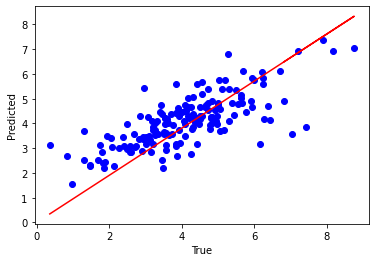

'R2=0.56, R2adj=-0.78, k=[0.95], RMSE=0.97'

In [195]:
def r2_zero_score(y_true,y_pred):
    #https://stats.stackexchange.com/questions/26176/removal-of-statistically-significant-intercept-term-increases-r2-in-linear-mo
    return 1 - (sum(y_true-y_pred)**2) / sum(y_true**2)

def rmse(y_true,y_pred):
    return np.sqrt(np.mean((y_pred-y_true)**2))

preds = preds.reshape((-1,))

a, _, _, _ = np.linalg.lstsq(y_test[:,np.newaxis],preds,rcond=None)

plt.plot(y_test, a*y_test, 'r-')
plt.scatter(y_test, preds, color='b')
plt.xlabel('True')
plt.ylabel('Predicted')

plt.show()

r2 = r2_score(y_test,preds)
r2_adj = (r2-r2_zero_score(y_test,preds))/r2
f'R2={np.around(r2,2)}, R2adj={np.around(r2_adj,2)}, k={np.around(a,2)}, RMSE={np.around(rmse(y_test, preds),2)}'

In [196]:
preds.mean(), y_test.mean(), preds.min(), y_test.min(), preds.max(),y_test.max()

(4.113102, 4.090493902439023, 1.5448871, 0.361, 7.360203, 8.755)